In [5]:
%load_ext autoreload
%autoreload 2

In [12]:
# load dependencies
import sys
import pickle
import os
import shutil
import json
import pandas as pd
import numpy as np
import rdkit.Chem as Chem
from numpy.random import default_rng
import torch
from ast import literal_eval
from torch import nn, optim
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc import Oracle
import subprocess

import matplotlib.pyplot as plt

In [ ]:
print(os.getcwd())

/home/springnuance/reinvent-hitl/Base-Code-Binh


In [8]:
from training_Bradley_Terry_model.bradley_terry import BradleyTerryModel
from training_Rank_ListNet_model.rank_listnet import RankListNetModel
from training_Score_Regression_model.score_regression import ScoreRegressionModel
from scripts.helper import load_drd2_dataset, write_REINVENT_config, change_config_json, \
                    read_scaffold_result, load_feedback_model, smiles_human_score, \
                    compute_fingerprints, retrain_feedback_model,\
                    create_drd2_dataset, combine_drd2_dataset, save_drd2_dataset
                        
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, matthews_corrcoef

### Loading analytics results

In [37]:
score_regression_analytics = {}
bradley_terry_analytics = {}
rank_listnet_analytics = {}

for acquisition in ["random", "uncertainty", "greedy"]:
    for sigma_noise in [0.0, 0.1]:
        score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"] = {}
        score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"] =\
            np.load(f"results_score_regression/acq_{acquisition}_noise_{sigma_noise}_metrics.npy", allow_pickle=True).tolist()
        score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"] =\
            np.load(f"results_score_regression/acq_{acquisition}_noise_{sigma_noise}_drd2_proba.npy", allow_pickle=True).tolist()
        score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"] =\
            np.load(f"results_score_regression/acq_{acquisition}_noise_{sigma_noise}_novelty_score.npy", allow_pickle=True).tolist()
        score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"] =\
            np.load(f"results_score_regression/acq_{acquisition}_noise_{sigma_noise}_sa_score.npy", allow_pickle=True).tolist()
        score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"] =\
            np.load(f"results_score_regression/acq_{acquisition}_noise_{sigma_noise}_logP_score.npy", allow_pickle=True).tolist()

        bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"] = {}
        bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"] =\
            np.load(f"results_bradley_terry/acq_{acquisition}_noise_{sigma_noise}_metrics.npy", allow_pickle=True).tolist()
        bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"] =\
            np.load(f"results_bradley_terry/acq_{acquisition}_noise_{sigma_noise}_drd2_proba.npy", allow_pickle=True).tolist()
        bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"] =\
            np.load(f"results_bradley_terry/acq_{acquisition}_noise_{sigma_noise}_novelty_score.npy", allow_pickle=True).tolist()
        bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"] =\
            np.load(f"results_bradley_terry/acq_{acquisition}_noise_{sigma_noise}_sa_score.npy", allow_pickle=True).tolist()
        bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"] =\
            np.load(f"results_bradley_terry/acq_{acquisition}_noise_{sigma_noise}_logP_score.npy", allow_pickle=True).tolist()
        
        rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"] = {}
        rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"] =\
            np.load(f"results_rank_listnet/acq_{acquisition}_noise_{sigma_noise}_metrics.npy", allow_pickle=True).tolist()
        rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"] =\
            np.load(f"results_rank_listnet/acq_{acquisition}_noise_{sigma_noise}_drd2_proba.npy", allow_pickle=True).tolist()
        rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"] =\
            np.load(f"results_rank_listnet/acq_{acquisition}_noise_{sigma_noise}_novelty_score.npy", allow_pickle=True).tolist()
        rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"] =\
            np.load(f"results_rank_listnet/acq_{acquisition}_noise_{sigma_noise}_sa_score.npy", allow_pickle=True).tolist()
        rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"] =\
            np.load(f"results_rank_listnet/acq_{acquisition}_noise_{sigma_noise}_logP_score.npy", allow_pickle=True).tolist()
        

### Benchmark 1: Model performance on predicting DRD2 activity using ROC-AUC score
### 

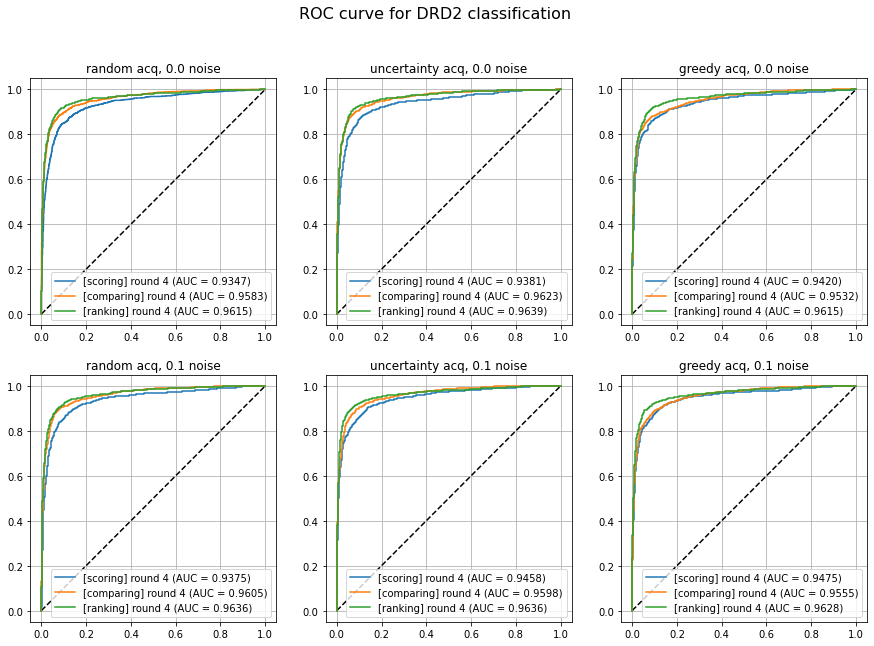

In [38]:
# Plotting 2 x 3 grid
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# flatten ax
ax = ax.flatten()

# subplot title
fig.suptitle("ROC curve for DRD2 classification", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            fpr_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            fpr_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            fpr_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['fpr']
            tpr_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['tpr']
            roc_auc_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["metrics"][REINVENT_round_name]['roc_auc']

            # Draw a diagonal line
            ax[index].plot([0, 1], [0, 1], 'k--')
            ax[index].plot(fpr_scoring, tpr_scoring, label=f"[scoring] round {REINVENT_round} (AUC = {roc_auc_scoring:.4f})")
            ax[index].plot(fpr_comparing, tpr_comparing, label=f"[comparing] round {REINVENT_round} (AUC = {roc_auc_comparing:.4f})")
            ax[index].plot(fpr_ranking, tpr_ranking, label=f"[ranking] round {REINVENT_round} (AUC = {roc_auc_ranking:.4f})")
            
            # turn on grid for each subplot
            ax[index].grid()
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='lower right')
            
        index += 1


### Benchmark 2: DRD2 activity probability distribution of molecules generated by REINVENT

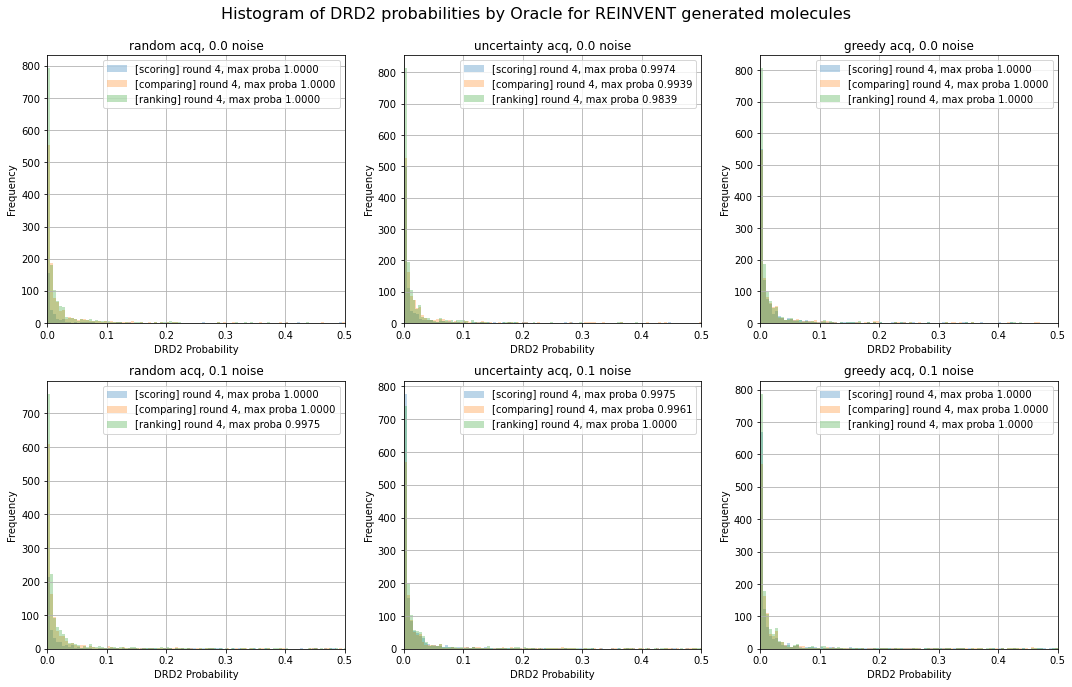

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten ax
ax = ax.flatten()

# Subplot title
fig.suptitle("Histogram of DRD2 probabilities by Oracle for REINVENT generated molecules", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            proba_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"][REINVENT_round_name]
            proba_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"][REINVENT_round_name]
            proba_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["drd2_proba"][REINVENT_round_name]

            max_proba_scoring = max(proba_scoring)
            max_proba_comparing = max(proba_comparing)
            max_proba_ranking = max(proba_ranking)
            # Plot histograms
            ax[index].hist(proba_scoring, bins=200, alpha=0.3, label=f"[scoring] round {REINVENT_round}, max proba {max_proba_scoring:.4f}")
            ax[index].hist(proba_comparing, bins=200, alpha=0.3, label=f"[comparing] round {REINVENT_round}, max proba {max_proba_comparing:.4f}")
            ax[index].hist(proba_ranking, bins=200, alpha=0.3, label=f"[ranking] round {REINVENT_round}, max proba {max_proba_ranking:.4f}")
            
            # Turn on grid for each subplot
            ax[index].grid()
            ax[index].set_xlim(0, 0.5)
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='upper right')
            ax[index].set_xlabel('DRD2 Probability')
            ax[index].set_ylabel('Frequency')
            
        index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Benchmark 3: Novelty of molecules generated by REINVENT using Tanimoto similarity

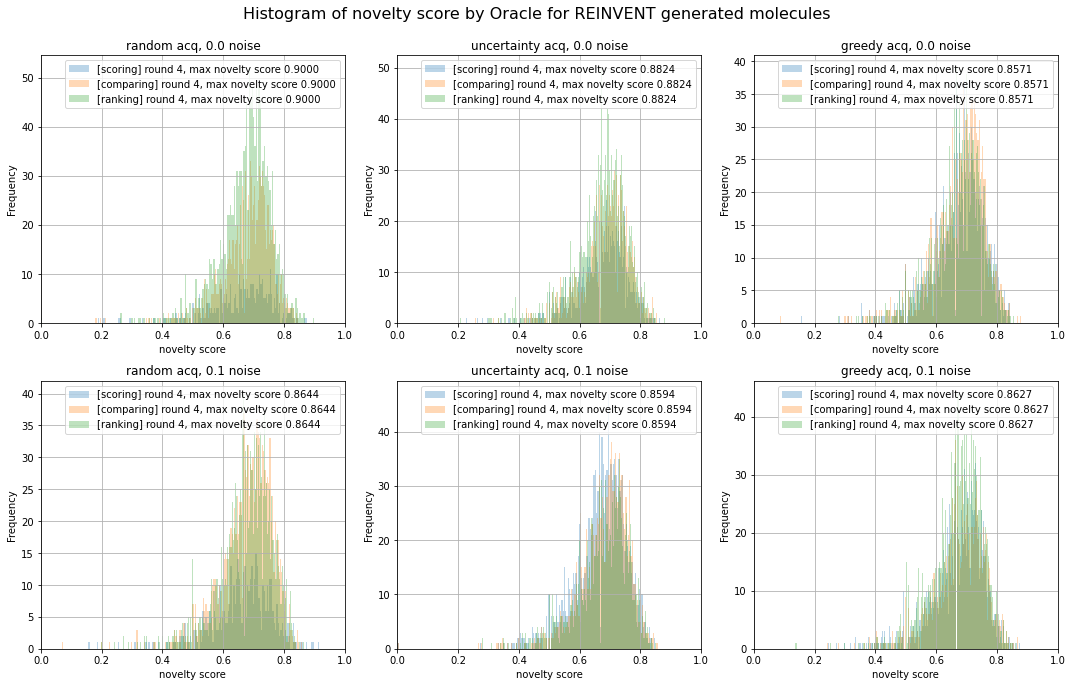

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten ax
ax = ax.flatten()

# Subplot title
fig.suptitle("Histogram of novelty score for REINVENT generated molecules", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            novelty_score_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"][REINVENT_round_name]
            novelty_score_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"][REINVENT_round_name]
            novelty_score_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["novelty_score"][REINVENT_round_name]

            max_novelty_score = max(novelty_score_scoring)
            max_novelty_score = max(novelty_score_comparing)
            max_novelty_score = max(novelty_score_ranking)

            # Plot histograms
            ax[index].hist(novelty_score_scoring, bins=200, alpha=0.3, label=f"[scoring] round {REINVENT_round}, max novelty score {max_novelty_score:.4f}")
            ax[index].hist(novelty_score_comparing, bins=200, alpha=0.3, label=f"[comparing] round {REINVENT_round}, max novelty score {max_novelty_score:.4f}")
            ax[index].hist(novelty_score_ranking, bins=200, alpha=0.3, label=f"[ranking] round {REINVENT_round}, max novelty score {max_novelty_score:.4f}")
            
            # Turn on grid for each subplot
            ax[index].grid()
            ax[index].set_xlim(0, 1.0)
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='upper right')
            ax[index].set_xlabel('novelty score')
            ax[index].set_ylabel('Frequency')
            
        index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Benchmark 4: Synthetic Accessibility (SA) score of molecules generated by REINVENT

SA score is calculated using RDKit implementation of the synthetic accessibility score as described in Ertl et al. (2009). The SA score is a measure of the complexity of a molecule, with higher scores indicating higher complexity. 

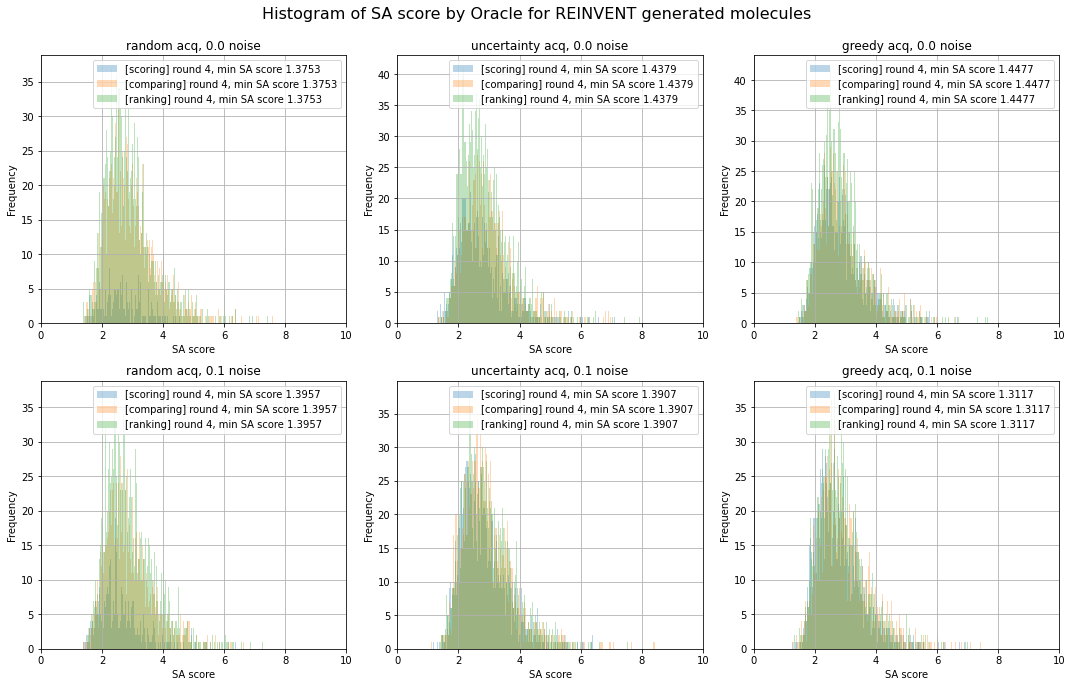

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten ax
ax = ax.flatten()

# Subplot title
fig.suptitle("Histogram of SA score for REINVENT generated molecules", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            sa_score_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"][REINVENT_round_name]
            sa_score_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"][REINVENT_round_name]
            sa_score_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["sa_score"][REINVENT_round_name]

            sa_min_score = min(sa_score_scoring)
            sa_min_score = min(sa_score_comparing)
            sa_min_score = min(sa_score_ranking)

            # Plot histograms
            ax[index].hist(sa_score_scoring, bins=200, alpha=0.3, label=f"[scoring] round {REINVENT_round}, min SA score {sa_min_score:.4f}")
            ax[index].hist(sa_score_comparing, bins=200, alpha=0.3, label=f"[comparing] round {REINVENT_round}, min SA score {sa_min_score:.4f}")
            ax[index].hist(sa_score_ranking, bins=200, alpha=0.3, label=f"[ranking] round {REINVENT_round}, min SA score {sa_min_score:.4f}")

            # Turn on grid for each subplot
            ax[index].grid()
            ax[index].set_xlim(0, 10) # SA score range from 0 to 10
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='upper right')
            ax[index].set_xlabel('SA score')
            ax[index].set_ylabel('Frequency')
            
        index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Benchmark 5: Pharmacokinetic (PK) parameter logP of molecules generated by REINVENT

PK parameters play a crucial role in understanding how a drug interacts with the body during drug development. These parameters provide insights into various aspects (ADME):

- Absorption: How the drug is absorbed after administration.
- Distribution: How the drug spreads across different bodily compartments or tissues.
- Metabolism: How the body processes or degrades the drug.
- Excretion: How the body eliminates or gets rid of the drug.


The logP parameter, or the partition coefficient, is a crucial molecular descriptor in medicinal chemistry and drug design. It quantifies the lipophilicity of chemical compounds and influences their pharmacokinetic properties

| LogP | Value Range | Characteristics | 
| --- | --- | --- |
| \< 1 | Too hydrophilic | Poor absorption, rapid excretion |
| 1 - 3 | Balanced hydrophilic and hydrophobic | Good absorption and bioavailability |
| 3 - 5 | Moderately hydrophobic | Potential absorption issues, consider formulation |
| \> 5 | Too hydrophobic | Poor solubility, potential toxicity, poor absorption |



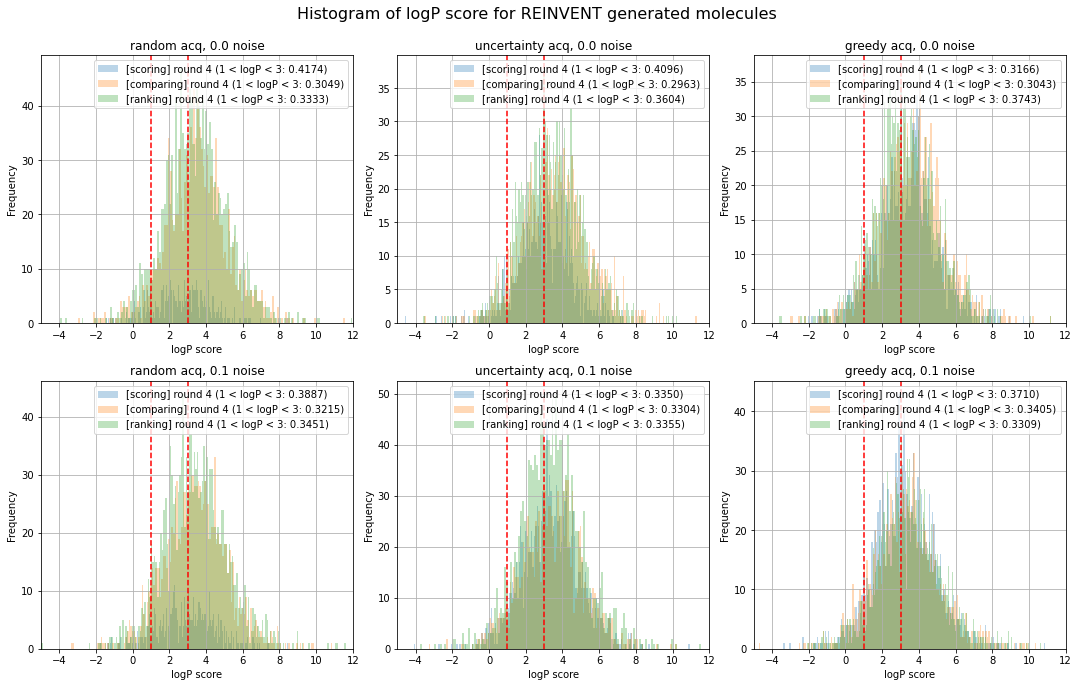

In [57]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Flatten ax
ax = ax.flatten()

# Subplot title
fig.suptitle("Histogram of logP score for REINVENT generated molecules", fontsize=16)

index = 0
for sigma_noise in [0.0, 0.1]:
    for acquisition in ["random", "uncertainty", "greedy"]:
        for REINVENT_round in [4]:
            REINVENT_round_name = f"REINVENT_round_{REINVENT_round}"
            logP_score_scoring = score_regression_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"][REINVENT_round_name]
            logP_score_comparing = bradley_terry_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"][REINVENT_round_name]
            logP_score_ranking = rank_listnet_analytics[f"acq_{acquisition}_noise_{sigma_noise}"]["logP_score"][REINVENT_round_name]

            # calculate percentage of molecules with logP score > 1 and < 3
            logP_score_scoring_1_3 = [x for x in logP_score_scoring if 1 < x < 3]
            logP_score_comparing_1_3 = [x for x in logP_score_comparing if 1 < x < 3]
            logP_score_ranking_1_3 = [x for x in logP_score_ranking if 1 < x < 3]

            logP_score_scoring_1_3_percentage = len(logP_score_scoring_1_3) / len(logP_score_scoring)
            logP_score_comparing_1_3_percentage = len(logP_score_comparing_1_3) / len(logP_score_comparing)
            logP_score_ranking_1_3_percentage = len(logP_score_ranking_1_3) / len(logP_score_ranking)

            # Plot histograms
            ax[index].hist(logP_score_scoring, bins=200, alpha=0.3, label=f"[scoring] round {REINVENT_round} (1 < logP < 3: {logP_score_scoring_1_3_percentage:.4f})")
            ax[index].hist(logP_score_comparing, bins=200, alpha=0.3, label=f"[comparing] round {REINVENT_round} (1 < logP < 3: {logP_score_comparing_1_3_percentage:.4f})")
            ax[index].hist(logP_score_ranking, bins=200, alpha=0.3, label=f"[ranking] round {REINVENT_round} (1 < logP < 3: {logP_score_ranking_1_3_percentage:.4f})")

            # Draw two red vertical lines at 1 and 3
            ax[index].axvline(x=1, color='r', linestyle='--')
            ax[index].axvline(x=3, color='r', linestyle='--')

            # Turn on grid for each subplot
            ax[index].grid()
            ax[index].set_xlim(-5, 12) # logP score range from -5 to 6
            ax[index].set_title(f"{acquisition} acq, {sigma_noise} noise")
            ax[index].legend(loc='upper right')
            ax[index].set_xlabel('logP score')
            ax[index].set_ylabel('Frequency')
            
        index += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()